# MECSim harmonic plotter

Plotter for ``MECSimOutput_Pot.txt`` format files which includes the harmonics.

Output the current against time and against voltage as 2 sets of images. Also splits the raw data output into dc and each harmonic using the header to find any non-zero frequency amplitudes. Harmonics are plotted individually as well as using a stacked output.

Each is output as PNG, PS and PDF in a clear format for inclusion in scientific journal articles.

## Script parameters

General parameters

In [17]:
# MECSim output filename
filename = '../output/MECSimOutput_Pot.txt'
# output to screen (useful if interactive)
iOutputToScreen = True
# output plots to screen (useful if interactive)
plotInteractive = True
# number of harmonics to plot if data available
number_harmonics = 5
# frequency bandwidth in Hz
frequency_bandwidth = 1

# directory for output of plots
output_dir = 'output/'
# location of parent directory: typically this file will be in python/ so the parent dir is '../'
parent_dir = '../'

### Load packages

In [18]:
import numpy as np
# load scipy for FFT functions
from scipy.fftpack import rfft, irfft, fftfreq
import matplotlib.pyplot as plt
import sys
if(plotInteractive):
    %matplotlib inline

Double check that interactive plotting mode is disabled if running this in script mode

In [19]:
thisCodeName = 'MECSimHarmonicPlotter.py'
nLength = len(thisCodeName)
tailString = sys.argv[0]
tailString = tailString[-nLength:]
if(tailString==thisCodeName):
    plotInteractive = False
    # next should be the file name
    filename = sys.argv[1]


## Define functions

Load MECSim output file

In [20]:
def ReadMECSimOut(filename):
    # set defaults to output a single freq, amp if amp>0
    freq_found = 1.0 # default null in pot exp files
    freq_test = 1.0 # default null in pot exp files
    freq_valid = False
    amp_found = 0.0
    # open file
    f = open(filename, 'r')
    # search for last line of header that is made by MECSim (always this line)
    for line in f:
        # non-zero frequency finder (freq first then confirm if Amp>0)
        if line.strip().startswith("Freq"):
            freq_test = float(line.strip().split()[1])
        if line.strip().startswith("Amp"):
            amp_test = float(line.strip().split()[1])
            if(amp_test > 0):
                amp_found = amp_test
                freq_found = freq_test
                freq_valid = True
        # end of header condition
        if line.strip() == "Post(ms):       0.000000E+00": break
    time = []
    eapp = []
    current = []
    for line in f:
        columns = line.split()
        time.append(float(columns[0]))
        eapp.append(float(columns[1]))
        current.append(float(columns[2]))
    return np.asfarray(time), np.asfarray(eapp), np.asfarray(current), amp_found, freq_found


## Read MECSim output file

In [21]:
eapp, current, time, amp_found, freq_found = ReadMECSimOut(filename)

Setup time, current and potential

In [22]:
t = np.array(time)
c = np.array(current)
ea = np.array(eapp)

In [23]:
if(amp_found>0):
    # dc + ac harmonics
    tWindow = 1.0/freq_found
else:
    # dc only
    tWindow = 1.0
    # set freq cutoff to be large (all DC)
    freq_found = 1e6
    number_harmonics = 0

In [24]:
def SmoothCurrent(t, i, e, tWindow):
    iSmooth = list(i)
    deltaT = t[1]-t[0] # assumes constant time steps
    tEnd = t[-1]
    tStart = t[0]
    iWindow = int(tWindow/deltaT)+1
    windowVal = []
    iMax = len(t)
    iMinW = -iWindow/2
    iMaxW = iMinW+iWindow-1
    for j in range(0, iWindow):
        windowVal.insert(0, i[j]) # insert at top/pop from bottom
    for ii in range(iMax):
        iMinW += 1
        iMaxW += 1
        if((iMinW>0) and (iMaxW<iMax)): # shift running total across by one point
            windowVal.pop()
            windowVal.insert(0, i[iMaxW])
        iSmooth[ii] = max(windowVal)
    return iSmooth

## Calculate harmonics

In [25]:
i_Harm = []
c_Harm = []
e_dc = []

# also do for the e_app (remove ac component from this)
W = fftfreq(ea.size, d=2*(t[1]-t[0]))
f_signal = rfft(ea)
cut_f_signal = f_signal.copy()
cut_f_signal[(W>0.5*freq_found)] = 0
cut_signal = irfft(cut_f_signal)
e_dc.append(cut_signal)

e_dc = np.array(e_dc).reshape(len(t))

# special treatment for dc (harmonic = 0)
W = fftfreq(c.size, d=2*(t[1]-t[0]))
f_signal = rfft(c)
cut_f_signal = f_signal.copy()
cut_f_signal[(W>0.5*freq_found)] = 0
cut_signal = irfft(cut_f_signal)
c_Harm.append(cut_signal)
i_Harm.append(SmoothCurrent(t, cut_signal, eapp, tWindow))

# save FFT for DC to use in interactive plot
W_dc = W.copy()
f_signal_dc = f_signal.copy()
cut_f_signal_dc = cut_f_signal.copy()
cut_signal_dc = cut_signal.copy()

# frequency based harmonics (n*freq)
for iH in range(number_harmonics):
    iHarm = iH + 1
    fH = float(iHarm)
    W = fftfreq(c.size, d=2*(t[1]-t[0]))
    f_signal = rfft(c)
    cut_f_signal = f_signal.copy()
    cut_f_signal[(W<(fH*freq_found-frequency_bandwidth))] = 0
    cut_f_signal[(W>(fH*freq_found+frequency_bandwidth))] = 0
    cut_signal = irfft(cut_f_signal)
    c_Harm.append(cut_signal)
    i_Harm.append(SmoothCurrent(t, cut_signal, eapp, tWindow))


In [26]:
plot_freq = W[(W>0)]
plot_amp = np.log(np.absolute(f_signal[(W>0)]))

print(number_harmonics, len(plot_freq), len(plot_amp))

(0, 8191, 8191)


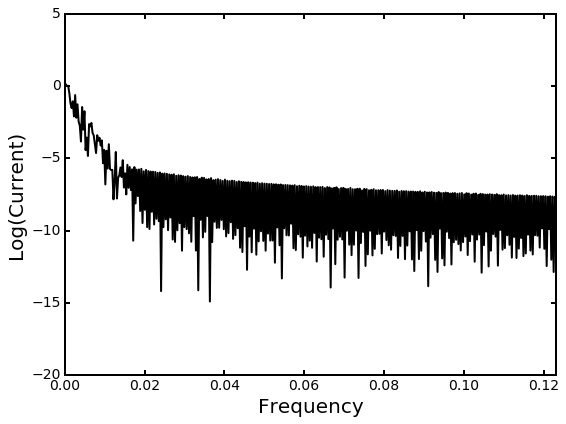

In [27]:
plt.figure(figsize=(8,6),dpi=100)
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.minor.width'] = 2
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
plt.plot(plot_freq, plot_amp, 'k')
plt.xlim([0,max(plot_amp)])
plt.xlabel('Frequency', fontsize=20)
plt.ylabel('Log(Current)', fontsize=20)
plt.tight_layout()
full_path = parent_dir + output_dir + 'MECSimOutput_fft'
plt.savefig(full_path + '.png')
plt.savefig(full_path + '.ps')
plt.savefig(full_path + '.pdf')

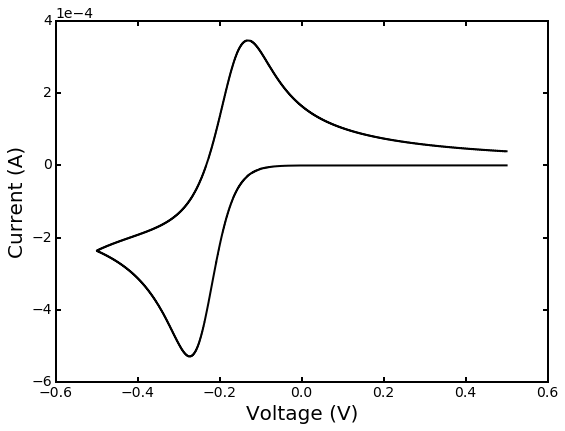

In [28]:
iH = 0
plt.figure(figsize=(8,6),dpi=100)
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
plt.xlabel('Voltage (V)', fontsize=20)
plt.ylabel('Current (A)', fontsize=20)
plt.tight_layout()
plt.plot(e_dc, i_Harm[iH], 'k')
full_path = parent_dir + output_dir + 'MECSimOutput_dc'
plt.savefig(full_path + '.png')
plt.savefig(full_path + '.ps')
plt.savefig(full_path + '.pdf')

In [29]:
for i in range(number_harmonics):
    iH = i + 1
    plt.figure(figsize=(8,6),dpi=100)
    plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    plt.xlabel('Time (s)', fontsize=20)
    plt.ylabel('Current (A)', fontsize=20)
    plt.tight_layout()
    plt.plot(t, i_Harm[iH], 'k')
    full_path = parent_dir + output_dir + 'MECSimOutput_H' + str(iH)
    plt.savefig(full_path + '.png')
    plt.savefig(full_path + '.ps')
    plt.savefig(full_path + '.pdf')

## Plot current against time

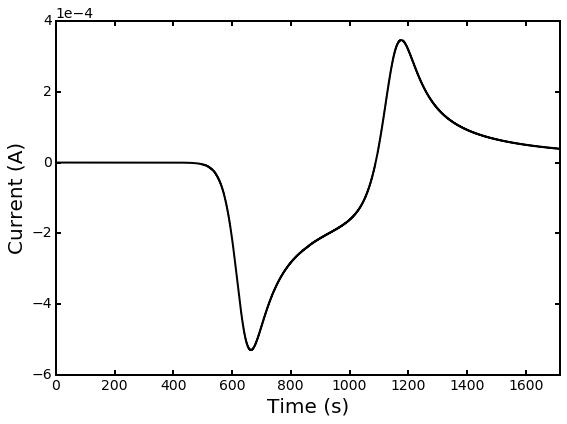

In [30]:
plt.figure(figsize=(8,6),dpi=100)
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.minor.width'] = 2
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
plt.plot(time, current, 'k')#, label='A', linewidth=2)
plt.xlim([0,time[-1]])
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Current (A)', fontsize=20)
plt.tight_layout()

full_path = parent_dir + output_dir + 'MECSimOutputCt'
plt.savefig(full_path + '.png')
plt.savefig(full_path + '.ps')
plt.savefig(full_path + '.pdf')

## Plot current against applied voltage

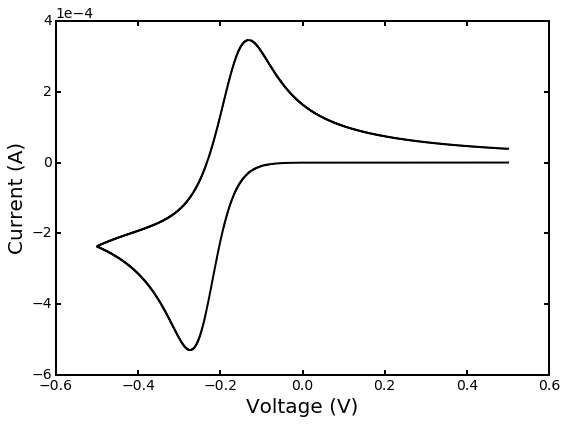

In [31]:
plt.figure(figsize=(8,6),dpi=100)
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
plt.plot(eapp, current, 'k')#, label='A', linewidth=2)
plt.xlabel('Voltage (V)', fontsize=20)
plt.ylabel('Current (A)', fontsize=20)
plt.tight_layout()

full_path = parent_dir + output_dir + 'MECSimOutputCV'
plt.savefig(full_path + '.png')
plt.savefig(full_path + '.ps')
plt.savefig(full_path + '.pdf')